# Proyek Klasifikasi Gambar: Flower Recognition

## Import Semua Packages/Library yang Digunakan

In [ ]:
import tensorflow as tf
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from google.colab import files

## Data Preparation

### Data Loading

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilasalsabila","key":"5fe23a51b2e30e75dc40d3e7330d41b1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 94% 211M/225M [00:01<00:00, 133MB/s]
100% 225M/225M [00:01<00:00, 127MB/s]


In [ ]:
with zipfile.ZipFile('flowers-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset_flowers')

In [ ]:
train_dir = '/content/dataset_flowers/flowers'

## Data Preprocessing

### Split Dataset

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:
class_indices = train_generator.class_indices

## Modelling

In [ ]:
class StopAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.85, target_val_accuracy=0.85):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        accuracy = logs.get('accuracy', 0)
        val_accuracy = logs.get('val_accuracy', 0)
        if accuracy >= self.target_accuracy and val_accuracy >= self.target_val_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy and {self.target_val_accuracy * 100}% val accuracy, stopping training!")
            self.model.stop_training = True

In [ ]:
checkpoint = ModelCheckpoint('best_flower_model.keras', monitor='val_accuracy', save_best_only=True)
stop_at_85_callback = StopAtAccuracy(target_accuracy=0.85, target_val_accuracy=0.85)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=80,
    validation_data=validation_generator,
    callbacks=[checkpoint, stop_at_85_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 406ms/step - accuracy: 0.3799 - loss: 1.5168 - val_accuracy: 0.5733 - val_loss: 1.0267
Epoch 2/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 315ms/step - accuracy: 0.6640 - loss: 0.8929 - val_accuracy: 0.7570 - val_loss: 0.6661
Epoch 3/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.7361 - loss: 0.7247 - val_accuracy: 0.7244 - val_loss: 0.7343
Epoch 4/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 319ms/step - accuracy: 0.7680 - loss: 0.6406 - val_accuracy: 0.7593 - val_loss: 0.6081
Epoch 5/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 318ms/step - accuracy: 0.7683 - loss: 0.6536 - val_accuracy: 0.7628 - val_loss: 0.6755
Epoch 6/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.8000 - loss: 0.5566 - val_accuracy: 0.7802 - val_loss: 0.5584
Epoch 7/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 325ms/step - accuracy: 0.7924 - loss: 0.5938 - val_accuracy: 0.7965 - val_loss: 0.5707
Epoch 8/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 344ms/step - accuracy: 0.8219 - loss: 0

## Evaluasi dan Visualisasi

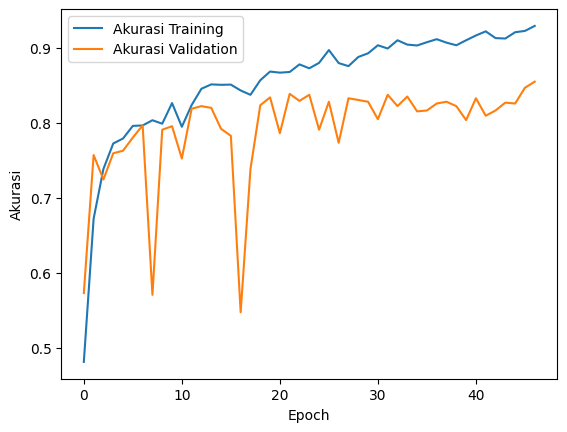

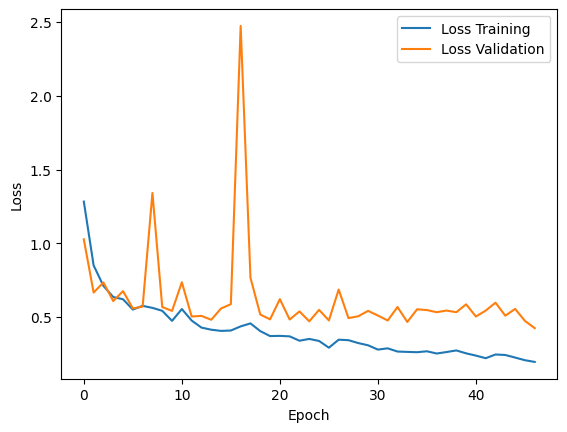

In [ ]:
# Plot akurasi dan loss
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [ ]:
# SavedModel
save_path = 'flower_recognition_model'
tf.saved_model.save(model, save_path)

In [ ]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('flower_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt66mxse7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136874351553872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351552144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351554256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351554064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351555408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351554448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351555024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351556560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136874351557520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13687435155

In [ ]:
# Convert ke TFJS
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 118.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

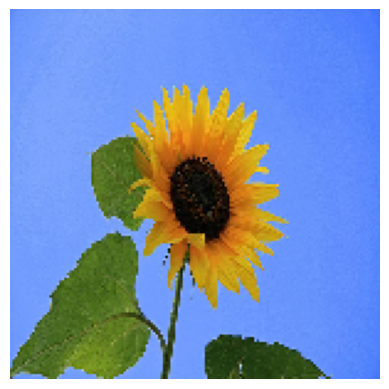

Prediksi: sunflower


In [ ]:
# Inference menggunakan TF-Lite
def predict_tflite_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    interpreter = tf.lite.Interpreter(model_path='flower_recognition_model.tflite')
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Membuat prediksi
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    classes = list(train_generator.class_indices.keys())
    print("Prediksi:", classes[np.argmax(prediction)])

# Test
predict_tflite_image('/content/dataset_flowers/flowers/sunflower/1044296388_912143e1d4.jpg')

In [ ]:
!pip freeze > requirements.txt